# Atmospherically Corrected Earth Engine Time Series 

### Overview

This notebook creates atmospherically corrected time series of satellite imagery using [Google Earth Engine](https://earthengine.google.com/) and the [6S emulator](https://github.com/samsammurphy/6S_emulator). 

### Supported missions

* Sentintel2
* Landsat8
* Landsat7
* Landsat5
* Landsat4

### Output

Average, cloud-*free* pixel values 

### Cloud masking

Standard cloud masks are used, i.e. FMASK for Landsat and ESA-QA60 for Sentinel 2.  There is no guarantee that they will find all clouds, a discussion on more advance and/or alternative cloud masking strategies is available [here](https://groups.google.com/forum/#!searchin/google-earth-engine-developers/cloud$20AND$20sentinel2%7Csort:relevance/google-earth-engine-developers/i63DS-Dg8Sg/FWenONUFBwAJ)

____

### Initialize

In [58]:
# interactive plots
# %matplotlib notebook 

# plots inside cells
%matplotlib inline

# standard modules
import os
import sys
import ee
import matplotlib
import pandas as pd
from IPython.display import display, Image
ee.Initialize()

# custom modules
base_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(base_dir,'atmcorr'))
from kml_reader import read_kml
from data_extraction import Extract as extract
from postProcessing import postProcessing
from plots import *

In [59]:
# debugging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### User Input

In [60]:
target = 'Yugama'

geom = read_kml(target, kmlFile='IAVCEI.kml')

# geom = ee.Geometry.Point(138.53587, 36.643136).buffer(80) #Yugama
# geom = ee.Geometry.Point(-84.230869, 10.197807).buffer(120) # Poas


startDate = '1985-01-01'
stopDate  = '2017-09-01'

missions = ['Sentinel2', 'Landsat8', 'Landsat7', 'Landsat5', 'Landsat4']

### Google Earth Engine TimeSeries

There are three methods for accessing Earth Engine data locally

* **`excel`**: reads data from excel file on disk


* **`getinfo`**: get data sent directly to this notebook


* **`googledrive`**: export to google drive


To specify just one method use the keyword

`method = ...`

otherwise, will try each method sequentially

In [61]:
from data_extraction import Extract as extract
data = extract.timeseries(target, geom, startDate, stopDate, missions, method='excel')

Loading from excel file


### Atmospherically correct the data

Perform atmospheric correction of wavebands between 0.4 and 2.2 microns (i.e. blue to shortwave-infrared).

In [62]:
from atmospheric_correction import run_atmcorr
data = run_atmcorr(data)

Surface reflectance already calculated
if override required --> data = run_atmcorr(data, force=True)


### Color Space

The hue-saturation-value color space is added to the dataset

In [63]:
# red-green-blue
rgb = list(zip(data['red'], data['green'], data['blue']))

# hue-staturation-value
hsv = [colorsys.rgb_to_hsv(x[0], x[1], x[2]) for x in rgb]

data['hue'] = [x[0] for x in hsv]
data['sat'] = [x[1] for x in hsv]
data['val'] = [x[2] for x in hsv]

### Manually inspect images?
The cloud mask is not perfect. You can visually inspect surface reflectance images.

* check everything looks good before batch export

In [64]:
from image_viewer import *

date = '2000-08-04'
region = view_window(geom)
maxValue = 0.3

rgb = surface_reflectance_inspector(data,\
                                    date=date, \
                                    bands = ['red', 'green', 'blue'])

jupyter_img = Image(url=rgb.getThumbUrl({
                                    'region':region,
                                    'min':0,
                                    'max':maxValue
                                    }))

display(jupyter_img)

scene datetime: 2000-10-14 01:12:10.159000
fileID: LE71080352000288EDC01


* batch upload image subsets to google drive

In [65]:
# from batch_quicklook import export_rgb

# # bucket = 'your-google-storage-bucket'
# # # You can get 5Gb of storage for free for each cloud project by enabling 
# # # App Engine Standard and using its default storage, in which case
# # # the name of the bucket will be '<project_name>.appspot.com'

# bucket = 'craterlakes-178002.appspot.com'
# export_rgb(data, region, bucket, targetName=target, maxValue=maxValue)

* batch download locally

In [66]:
# from batch_quicklook import download_rgb

# local_dir = '/home/sam/Dropbox/HIGP/Crater_Lakes/Corentin/'+target+'/images/original'

# # download_rgb(target, bucket, local_dir)

* manually remove the images you don't want to keep in the plots

In [67]:
# from manual_inspection import add_clean_column

# # I keep a separate 'clean' directory
# clean_dir = os.path.join(os.path.dirname(local_dir), 'clean')

# # add a 'clean' column to the excel file which tracks which images are in the clean_dir
# data = add_clean_column(data, clean_dir)

### Save post-processing to excel

In [68]:
from data_extraction import *
data = Excel.save(data, target)

### Time Series Plots

In [69]:
from plots import Plot
plot = Plot(data, '1986-01-01','2018-01-01')
basedir = '/home/sam/Dropbox/HIGP/Crater_Lakes/Corentin/'
fileNamePrefix = '/home/sam/Desktop/'+target
# fileNamePrefix = basedir+target+'/plots/v3/'+target
# fileNamePrefix=False

In [70]:
# from plot_field_data import *
# plot_single_variable('fieldT', target, '1985-01-01','2018-01-01')

/home/sam/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


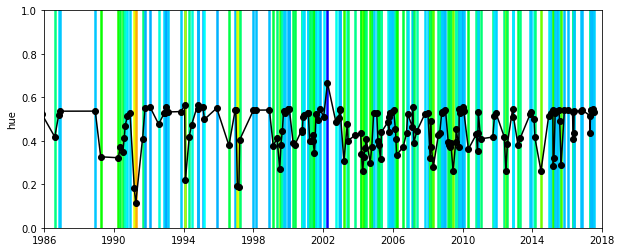

In [71]:
plot.hue(fileNamePrefix=fileNamePrefix)

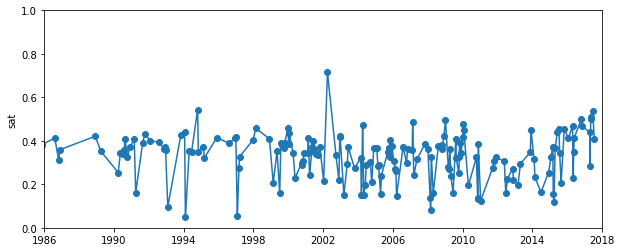

In [72]:
plot.graph('sat', ylim=[0,1], fileNamePrefix=fileNamePrefix)

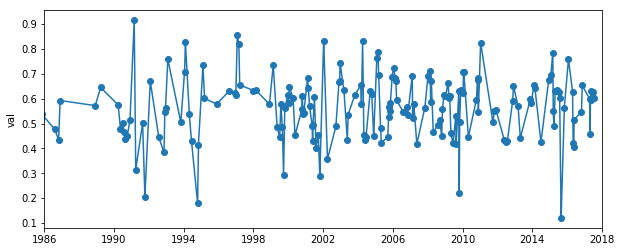

In [73]:
plot.graph('val', fileNamePrefix=fileNamePrefix)

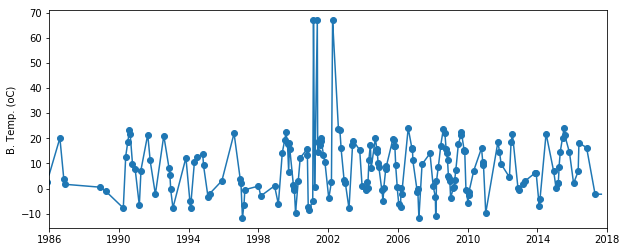

In [74]:
plot.graph('Temp_1', ylabel='B. Temp. (oC)', fileNamePrefix=fileNamePrefix)